# Проект 5. Компьютер говорит "НЕТ"

#### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, roc_auc_score, roc_curve

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#### Читаем данные из файла и смотрим их описание

In [2]:
data = pd.read_csv('train.csv')
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0
3,16222,SCH,F,53,N,N,0,0,2,2,3,10000,N,0
4,101655,GRD,M,48,N,N,0,1,1,2,3,30000,Y,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


#### Соотношение нулей и единиц в целевой переменной

<AxesSubplot:>

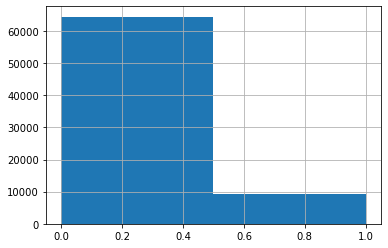

In [4]:
data.default.hist(bins=2)

#### Данные по графе "образование"

<AxesSubplot:>

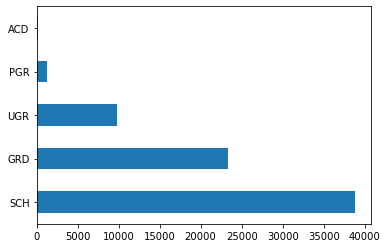

In [5]:
data.education.value_counts().plot.barh()

#### Заполним пропуски сгенерированными значениями. Для генерации будем использовать данные о том, как часто появляется то или иное значение в данных. Применяем этот подход, потому что пропущенно довольно мало данных и это будет всяко лучше, чем заполнить средним значением.

<AxesSubplot:>

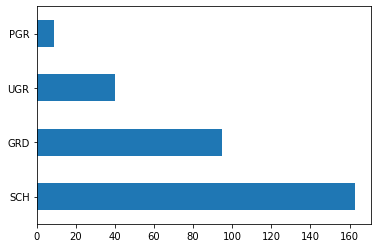

In [6]:
# вероятности появления различных значений признака 'education'
edu_proba = (data.education.value_counts() / data.education.count())
# список значений
edu_values = edu_proba.index
# кол-во пустых значений
size = data.loc[data.education.isna(), 'education'].shape[0]
# генерируем значения рандомом придерживаясь частоты их появления в датасете
generated_edu = np.random.choice(edu_values, size=size, p=edu_proba)

# построим для проверки
pd.Series(generated_edu).value_counts().plot.barh()

In [7]:
data.loc[data.education.isna(), 'education'] = generated_edu

<AxesSubplot:>

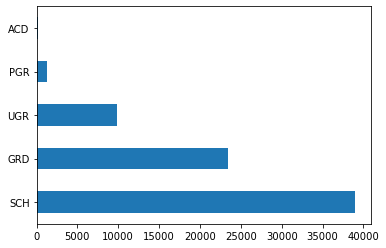

In [8]:
data.education.value_counts().plot.barh()

#### Колонки с числовыми значениями и их прологарифмированное распределение

/home/pavlk/APPS/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


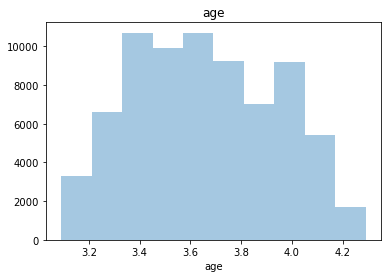

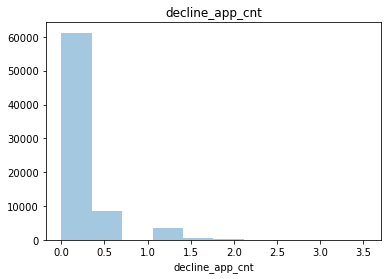

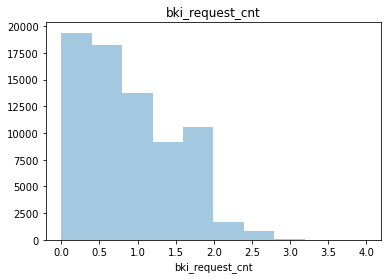

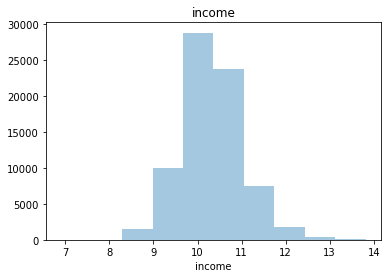

In [9]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols:
    plt.figure()
    sns.distplot(np.log(data[i] + 1), kde = False, rug=False, bins=10)
    plt.title(i)
    plt.show()

#### Разобьем клиентов по группам: те кто возвращает кредит и кто нет

In [10]:
defaulters = np.log(data.loc[data.default == 1, ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']] + 1)
nondefaulters = np.log(data.loc[data.default == 0, ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']] + 1)

#### Посмотрим средний возраст клиентов по группам

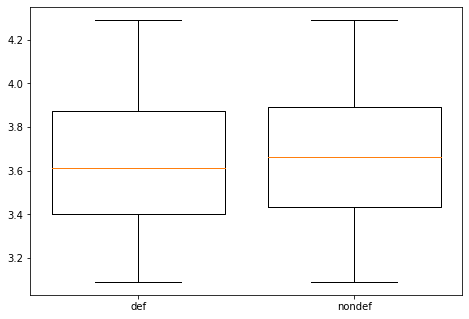

In [11]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.boxplot([defaulters.age, nondefaulters.age], labels=['def', 'nondef'], widths=[0.8, 0.8], meanline=True);

#### Посмотрим среднее кол-во отказов клиентам по группам

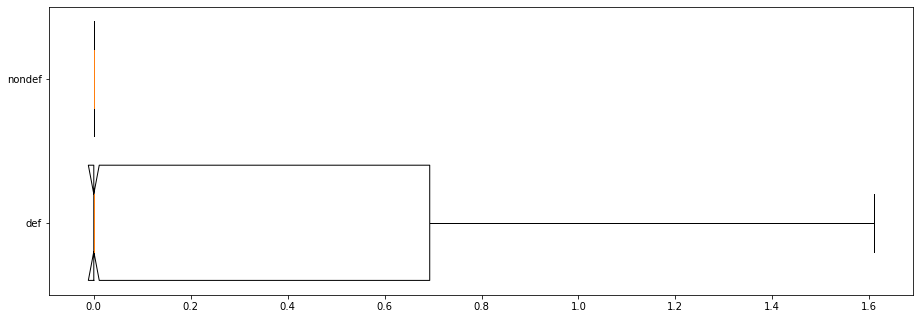

In [12]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 1])
axes.boxplot([defaulters.decline_app_cnt, nondefaulters.decline_app_cnt], labels=['def', 'nondef'], meanline=True, widths=[0.8, 0.8], autorange=False, vert=False, notch=True, sym='');

In [13]:
# На графике не понятно среднее значение, посчитаем его вручную
data.groupby('default').decline_app_cnt.mean()

default
0    0.240877
1    0.515472
Name: decline_app_cnt, dtype: float64

#### Посмотрим среднее кол-во обращений в БКИ по группам

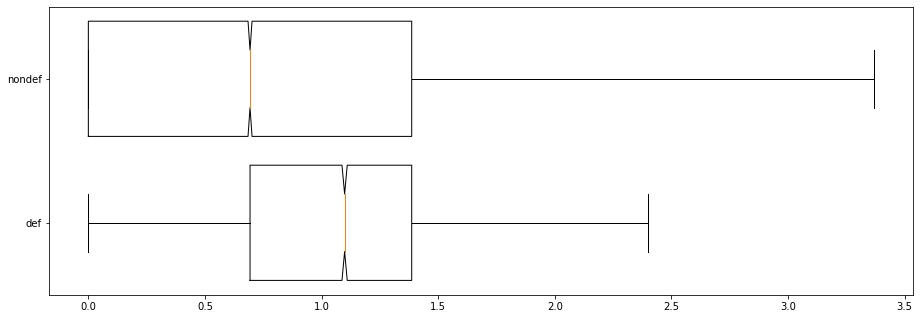

In [14]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 1])
axes.boxplot([defaulters.bki_request_cnt, nondefaulters.bki_request_cnt], labels=['def', 'nondef'], meanline=True, widths=[0.8, 0.8], autorange=False, vert=False, notch=True, sym='');

#### Посмотрим среднее зарплаты клиентов по группам

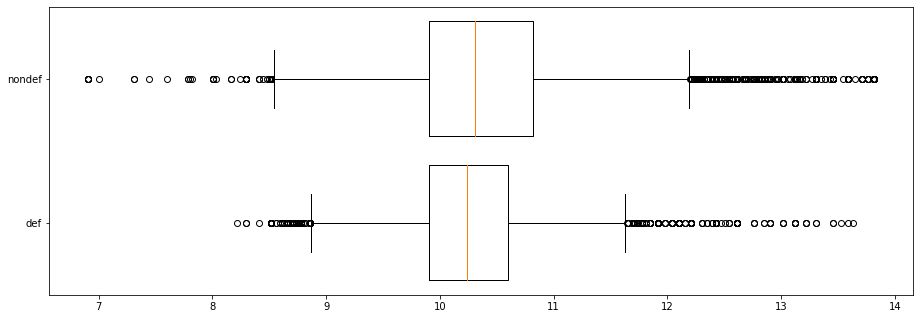

In [15]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 2, 1])
axes.boxplot([defaulters.income, nondefaulters.income], vert=False, labels=['def', 'nondef'], widths=[0.8, 0.8], meanline=False);

In [16]:
# Снова график не сликшом нагляден, посчитаем вручную
data.groupby('default').income.mean()

default
0    41799.713288
1    36288.113316
Name: income, dtype: float64

### Оценим корреляцию признаков

,age,decline_app_cnt,bki_request_cnt,income
age,1.000000,-0.111175,0.046265,-0.018900
decline_app_cnt,-0.111175,1.000000,0.155894,-0.021687
bki_request_cnt,0.046265,0.155894,1.000000,0.082983
income,-0.018900,-0.021687,0.082983,1.000000


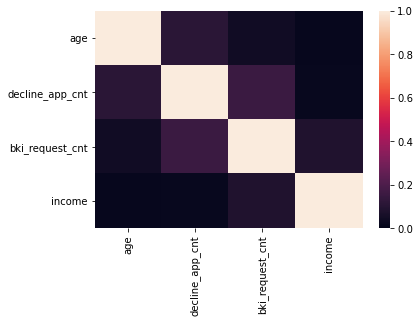

In [17]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)
data[num_cols].corr()

### Вывод
Есть лёгкая связь между кол-вом обращеий в Бюро кредитных историй и кол-вом отказов. Это кажется логичным, ведь у дефолтных клиентов больше заявок на кредиты, а значит их пробивали чаще в БКИ. Есть также небольшая корреляция с возрастом, но она отрицательна, это говорит о более серьёзном отношении к деньгам с возрастом. Ну и последнее, это чем больше доход, тем чаще люди обращаются за кредитом. Это кажется логичным, ведь тем увереннее они в том, что его смогут погасить и надежнее чувствуют себя в финансовом плане.

## Значимость числовых признаков

<AxesSubplot:>

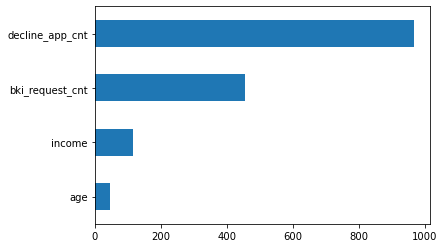

In [18]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самым значимым оказался признак `decline_app_cnt` - количество отказов

#### Преобразуем бинарные признаки

In [19]:
# Для бинарных признаков мы будем использовать LabelEncoder
bin_cols = ['car', 'car_type', 'foreign_passport', 'good_work']
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся впреобразовании    
data.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,1,1,0,0,1,1,2,18000,0,0
1,63161,SCH,F,59,0,0,0,0,3,2,3,19000,0,0
2,25887,SCH,M,25,1,0,2,0,1,1,2,30000,1,0
3,16222,SCH,F,53,0,0,0,0,2,2,3,10000,0,0
4,101655,GRD,M,48,0,0,0,1,1,2,3,30000,1,0


In [20]:
# Преобразуем строковые значения в числовые у колонок 'sex' и 'education' с помощью LabelEncoder
cols = ['sex', 'education']
label_encoder = LabelEncoder()

for column in cols:
    data[column] = label_encoder.fit_transform(data[column])

## Значимость категориальных признаков

<AxesSubplot:>

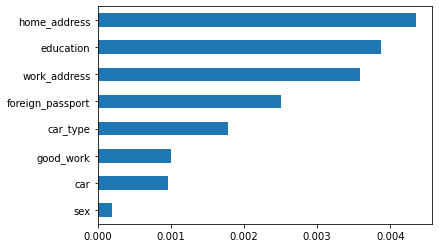

In [21]:
cat_cols = ['work_address', 'home_address', 'sex', 'education']
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самым значимым оказался признак `home_address` - домашний адрес клиента

Переведём категориальные признаки в колонки с помощью OneHotEncoder (принцип как у `get_dummies`) и посмотрим кол-во получившихся колонок

In [22]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat.shape

(73799, 13)

#### Стандартизируем переменные

In [23]:
X_num = StandardScaler().fit_transform(data[num_cols].values)

#### Объединим все преобразованные данные в одну таблицу

In [24]:
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

#### Разбиваем на обучающую и проверочную выборки

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

## 1. Используем Логистическую Регрессию в качестве классификатора

#### Обучим модель и построим ROC-кривую

/home/pavlk/APPS/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


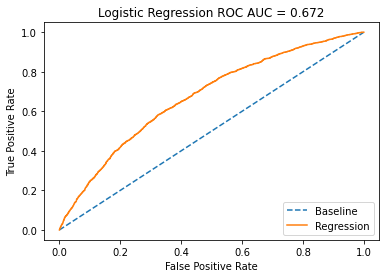

In [26]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Вывод
Площадь под кривой получилась равная 0.67, что слегка лучше чем просто случайное предсказывание. У нас есть куда улучшать модель.

Показатель точности на обучающей выборке

In [27]:
accuracy_score(y_train, model.predict(X_train))

0.8717288571960907

Показатель точности на тестовой выборке

In [28]:
accuracy_score(y_test, model.predict(X_test))

0.875609756097561

## 2. Используем k -ближайших соседей в качестве классификатора

In [29]:
# Зададим 3 в качестве кол-ва соседей
model = KNeighborsClassifier(n_neighbors=3)
kf = KFold(n_splits=10)

# Посмотрим на среднее значение метрики accuracy
accs = cross_val_score(model, X, Y, cv=kf, scoring="accuracy")
accs.mean()

0.840350039352135

## 3. Попробуем дерево решений в качестве классификатора

#### Подготовка:
Сначала уравняем количество данных нулей и единиц в целевой переменной. Да, придется убрать большую часть данных, но я бы хотел попробовать эту модель и посмотреть на результаты, несмотря ни на что.

In [30]:
n = data.default.value_counts()[1]
zeros = data.loc[data.default == 0][:n]
ones = data.loc[data.default == 1]
balanced = pd.concat([zeros, ones], axis=0, ignore_index=True)
# Для бинарных признаков мы будем использовать LabelEncoder
bin_cols = ['car', 'car_type', 'foreign_passport', 'good_work']
label_encoder = LabelEncoder()

for column in bin_cols:
    balanced[column] = label_encoder.fit_transform(balanced[column])

# Преобразуем строковые значения в числовые у колонок 'sex' и 'education' с помощью LabelEncoder
cols = ['sex', 'education']
label_encoder = LabelEncoder()

for column in cols:
    balanced[column] = label_encoder.fit_transform(balanced[column])

X_cat = OneHotEncoder(sparse = False).fit_transform(balanced[cat_cols].values)

# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(balanced[num_cols].values)

# Объединяем
X_bal = np.hstack([X_num, balanced[bin_cols].values, X_cat])
Y_bal = balanced['default'].values

x_train, x_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.3, shuffle=False)
clf_bal = DecisionTreeClassifier(max_depth=500)
clf_bal.fit(x_train, y_train)
y_pred = clf_bal.predict(x_test)
f1_bal = f1_score(y_test, y_pred)

# Результат метрики f1_score
print(f1_bal)

0.5250458956202466


### Вывод
Показатель f1_score оказался низким. Это можно объяснить тем, что я удалил около 70% всех данных, для того, чтобы уравнять количество нулей и единиц в целевой переменной

## Посмотрим метрики для DecisionTreeClassifier и посмотрим нет ли переобучения

In [31]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [32]:
clf = DecisionTreeClassifier()
cv_metrics = cross_validate(clf, X, Y, cv=5, scoring='f1_micro', return_train_score=True)

[train] F1-score = 0.98 +/- 0.00
[valid] F1-score = 0.78 +/- 0.00


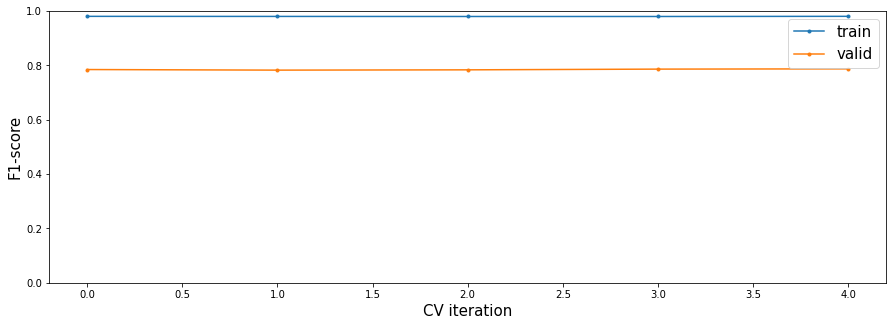

In [33]:
plot_cv_metrics(cv_metrics)

### Вывод
Переобучение на лицо, поэтому попробуем уменьшить глубину 

[train] F1-score = 0.87 +/- 0.00
[valid] F1-score = 0.87 +/- 0.00


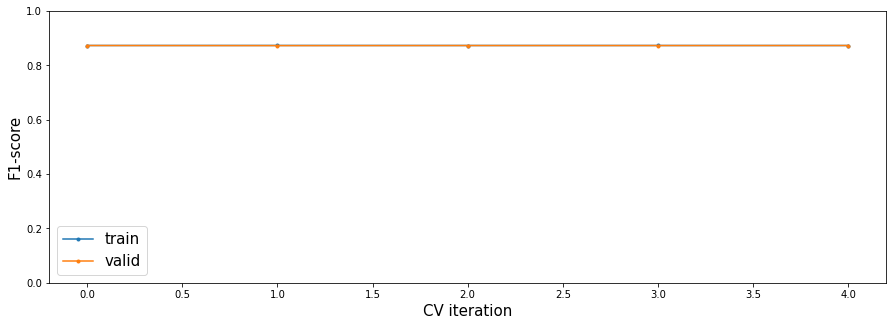

In [34]:
clf = DecisionTreeClassifier(max_depth=5, random_state=456)
cv_metrics = cross_validate(clf, X, Y, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

### Вывод
Как мы видим уменьшение глубины деревьев помогло избавиться от переобучения и улучшить наш показатель f1_score

## Посмотрим метрики для KNeighborsClassifier

[train] F1-score = 0.88 +/- 0.00
[valid] F1-score = 0.86 +/- 0.00


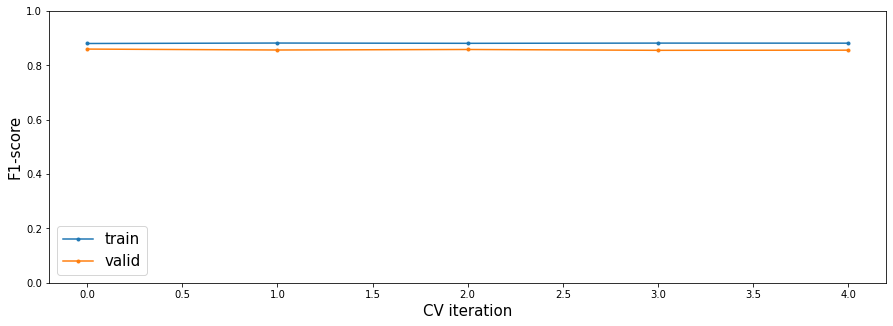

In [35]:
clf = KNeighborsClassifier()
cv_metrics = cross_validate(clf, X, Y, cv=5, scoring='accuracy', return_train_score=True)
plot_cv_metrics(cv_metrics)

[train] F1-score = 0.87 +/- 0.00
[valid] F1-score = 0.87 +/- 0.00


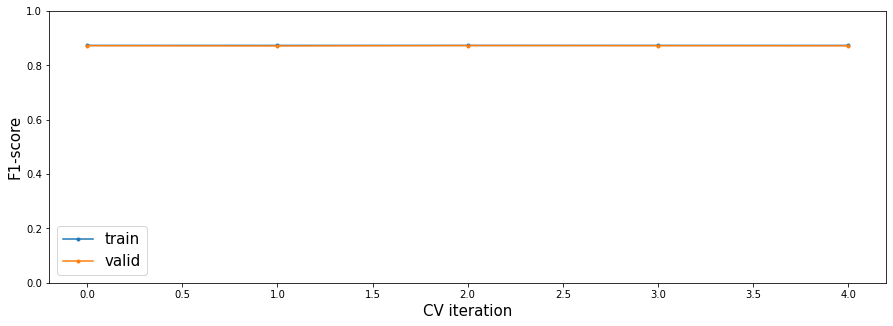

In [36]:
clf = KNeighborsClassifier(n_neighbors=18)
cv_metrics = cross_validate(clf, X, Y, cv=5, scoring='accuracy', return_train_score=True)
plot_cv_metrics(cv_metrics)

### Вывод
Для того, чтобы добиться "сближения" графиков пришлось увеличить количество соседей до 18. Если держать кол-во соседей меньше 10, то между графиками остается значительная разница.

## Посмотрим метрики для LogRegression

/home/pavlk/APPS/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pavlk/APPS/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[train] F1-score = 0.87 +/- 0.00
[valid] F1-score = 0.87 +/- 0.00


/home/pavlk/APPS/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


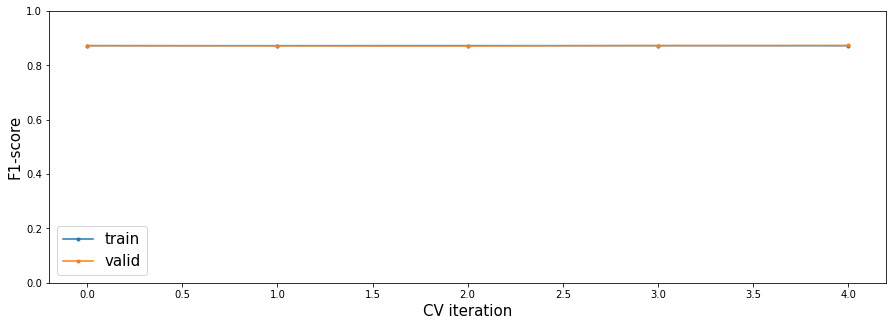

In [37]:
clf = LogisticRegression()
cv_metrics = cross_validate(clf, X, Y, cv=5, scoring='accuracy', return_train_score=True)
plot_cv_metrics(cv_metrics)

### Вывод
Как мы видим классификатор логистической регрессии не переобучается и показывает значение метрики f1_score в районе 0.87.

### Прежде, чем перейти к выводам, попробуем найти гиперпараметры для логистической регрессии

#### Поиск гиперпараметров для логистической регрессии

In [38]:
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 10, 100)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# Выведем результат
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.5922827933410924


#### Теперь построим логистическую регрессию с найденными параметрами

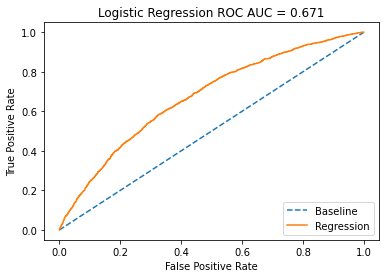

In [39]:
model = LogisticRegression(C=1.5922827933410924, penalty='l2')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Выводы по проекту № 5

Итак, опираясь на проделанную работу я могу сказать, что для повышения показания метрик, нам необходимо уделить большее внимание предварительной обработке данных. Можно сделать следующее:
- попробовать сгенерировать дополнительные признаки, например, с помощью PolynomialFeatures
- можно попробовать найти дополнительную информацию и добавить её в датасет
- можно поменять стратегию заполнения пустых полей в поле `education` и добавить новую категорию `unknown` или же удалить эти данные из набора и посмотреть как изменится результат
- возможно образование коррелирует с другим признаком и подобрать новые значения с этой стороны
В целом, есть куда потратить время, ведь не зря на предобработку уходит до 80% всего времени. В нашей команде из 2х человек работой с данными занимался Андрей Фёдоров, я же взялся за то, чтобы попробовать результативность каждой модели.

Говоря о гиперпараметрах, мы видим, что значения модели с параметрами по умолчанию - это и есть тот вариант, когда мы достигаем лучшего результата в нашей модели.

В своём проекте я постарался использовать и применить все 3 модели, что мы прошли в этом модуле и посмотреть на их результаты. Конечно, еще придется набраться опыта и начать понимать, когда одна модель более предпочтительна, чем другая. Но на данном этапе я вижу, что Логистическая Регрессия, К-соседей выдают приблизительно одинаковый результат в районе 0.8. Хотя я до конца не уверен, можно ли сравнивать между собой различные метрики (accuracy, f1_score и т.д.) А Деревья не очень подходят под эти данные, потому что очень большая разница у целевого показателя между кол-вом 0 и 1.